In [25]:
import sys
sys.path.append('..')

import numpy as np
import sqlite3

from PIL import Image
from sklearn.model_selection import train_test_split
from src.pipeline import *
from torch.utils.data import Dataset, Subset

class PokemonPalDatasetV2(Dataset):
    def __init__(self, transform=None):
        self.conn = sqlite3.connect(DB_NAME)
        self.transform = transform
        self.processed = Step.cropped.value
        self.rows: List[List[str]] = []

    def fetchall(self):
        cursor = self.conn.cursor()
        cursor.execute("SELECT bucket || '/' || path AS fullpath, CASE WHEN label='pokemon' THEN 0 ELSE 1 END FROM metadata WHERE step = ? ORDER BY created_at ASC", (self.processed,))
        self.rows = cursor.fetchall()
        print(f"Fetched {len(self.rows)} records.")

    def __len__(self):
        cursor = self.conn.cursor()
        cursor.execute("SELECT COUNT(*) FROM metadata WHERE step = ?", (self.processed,))
        count = cursor.fetchone()[0]
        return count

    def __getitem__(self, idx):
        if len(self.rows) == 0:
            self.fetchall()

        fullpath, label = self.rows[idx]
        image = Image.open(fullpath).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


dataset = PokemonPalDatasetV2()
dataset.fetchall()

indices_pokemon = [i for i, (_, label) in enumerate(dataset.rows) if label == 0]
indices_pal = [i for i, (_, label) in enumerate(dataset.rows) if label == 1]

num_samples = min(len(indices_pokemon), len(indices_pal))

indices_pokemon = np.random.choice(indices_pokemon, num_samples, replace=False)
indices_pal = np.random.choice(indices_pal, num_samples, replace=False)

balanced_indices = np.concatenate([indices_pokemon, indices_pal])
train_idx, test_idx = train_test_split(balanced_indices, test_size=0.2, random_state=42)

Fetched 37443 records.


Total images: 37443
Number of Pokemon images: 207
Number of Pal images: 207
Train dataset size: 331
Test dataset size: 83


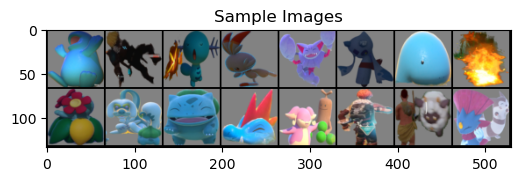

In [26]:
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Subsetの __getitem__() はインスタンス化時点の設定を継承するので、transform の指定は直前で行う
dataset.transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# Data Summary
print(f"Total images: {len(dataset.rows)}")
print(f"Number of Pokemon images: {len(indices_pokemon)}")
print(f"Number of Pal images: {len(indices_pal)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Show a transformed image sample from the dataset
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

sample_indices = np.random.choice(len(train_dataset), 16)
sample_images = [train_dataset[i][0] for i in sample_indices]
out = torchvision.utils.make_grid(sample_images)
imshow(out, title="Sample Images")


Epoch 1: Train Loss = 2.88328549691609, Test Loss = 0.6930883526802063
Epoch 2: Train Loss = 0.6737777221770513, Test Loss = 0.6115079919497172
Epoch 3: Train Loss = 0.6143531316802615, Test Loss = 0.6207517584164938
Epoch 4: Train Loss = 0.5600480323746091, Test Loss = 0.5303171823422114
Epoch 5: Train Loss = 0.4990154192561195, Test Loss = 0.48494191467761993


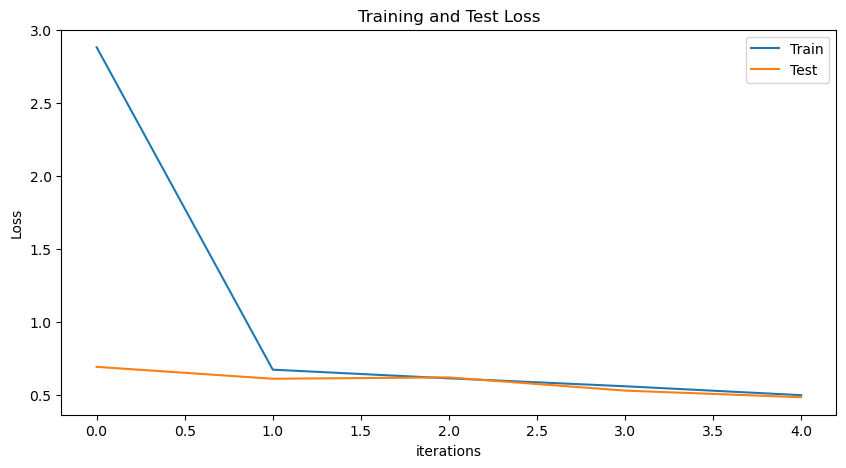

In [28]:
import sys
sys.path.append('..')

import torch
import os
from torch.utils.data import DataLoader
from torchvision import transforms
from src.SimpleCNN import SimpleCNN
from safetensors.torch import save_file

# Training code
def train(model, optimizer, criterion, train_loader, test_loader, num_epochs, device):
    tensors = {}
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_test_loss = 0.0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(running_test_loss/len(test_loader))
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Test Loss = {test_losses[-1]}")
        
    # Save the model
    model_dir = '../models/'
    snapshots_dir = f"{model_dir}snapshots/"
    if not os.path.exists(snapshots_dir):
        os.makedirs(snapshots_dir)
    tensors = {name: param for name, param in model.named_parameters()}
    save_file(tensors, f"{snapshots_dir}SimpleCNN_{epoch+1}_{image_size}x{image_size}.safetensors")
    save_file(tensors, f"{model_dir}model.safetensors")

    # Plotting the losses
    plt.figure(figsize=(10,5))
    plt.title("Training and Test Loss")
    plt.plot(train_losses,label="Train")
    plt.plot(test_losses,label="Test")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

image_size = 256

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(image_size=image_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])
dataset.transform = transform
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Fixing the batch size mismatch error
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs=5, device=device)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

model.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # print images
        for i in range(len(images)):
            imshow(images.cpu()[i])
            print('GroundTruth: ', labels[i])
            print('Output: ', outputs[i])
